I/O, Util, Boilerplate

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
johnsonData = pd.read_excel("PHYS 214/Johnson Noise Measurements.xlsx")
shotNoiseData = pd.read_excel("PHYS 214/Shot Noise Data.xlsx")

Anomaly Detection

In [44]:
import sklearn.ensemble as ens

In [58]:
#workedJohnson = johnsonData.drop(
#    ['dR', 'dBandwidth', 'dVT', 'Output Standard Error', 'dProduct', 'Voltage Calc Error'], axis=1)
workedJohnson = johnsonData
workedshotNoise = shotNoiseData.drop(['dVdc', 'dIdc', 'ddelF', 'dVsq', 'ddelIsq', 'ddelsq2f'], axis=1)

In [5]:
jForest = ens.IsolationForest().fit(workedJohnson)
jresult = jForest.predict(workedJohnson)

In [59]:
sForest = ens.IsolationForest().fit(workedshotNoise)
sresult = sForest.predict(workedshotNoise)

In [60]:
jInliers = johnsonData[jresult == 1]
jOutliers = johnsonData[jresult == -1]
sInliers = shotNoiseData[sresult == 1]
sOutliers = shotNoiseData[sresult == -1]

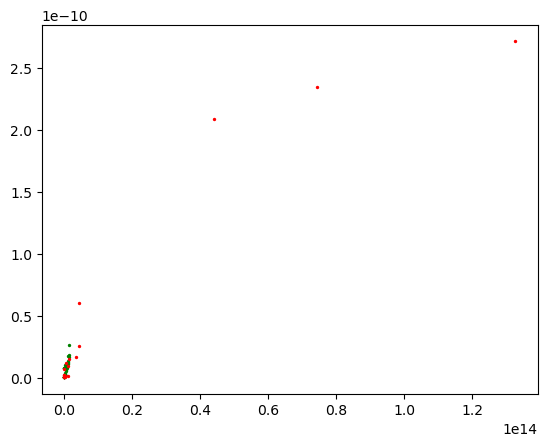

In [61]:
plt.scatter(jInliers['Product'], jInliers['Voltage'], color="green", s=2)
plt.scatter(jOutliers['Product'], jOutliers['Voltage'], color="red", s=2)

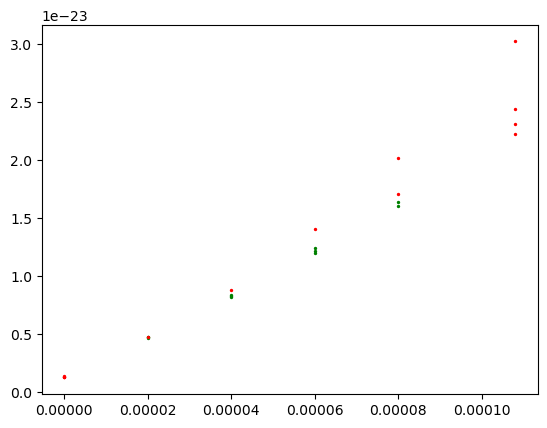

In [62]:
plt.scatter(sInliers['Idc'], sInliers['delsq2f'], color="green", s=2)
plt.scatter(sOutliers['Idc'], sOutliers['delsq2f'], color="red", s=2)

Curve Fitting

In [63]:
#Linear Fitting
def lin(B, x):
    #m*x + b
    return B[0]*x + B[1]

linModel = sp.odr.Model(lin)

In [64]:
johnsonFitData = sp.odr.Data(jInliers['Product'].to_numpy(), jInliers['Voltage'].to_numpy(), 
                             wd=1/jInliers['dProduct'].to_numpy(), we=1/jInliers['Voltage Calc Error'].to_numpy())
johnsonRegression = sp.odr.ODR(johnsonFitData, linModel, beta0=[1.23E-23, 1.4E-12])

In [65]:
shotNoiseFitData = sp.odr.Data(sInliers['Idc'].to_numpy(), sInliers['delsq2f'].to_numpy(), 
                             wd=1/sInliers['dIdc'].to_numpy(), we=1/sInliers['ddelsq2f'].to_numpy())
shotNoiseFitData = sp.odr.ODR(shotNoiseFitData, linModel, beta0=[1.33E-24, 1.8E-19])

In [66]:
out = johnsonRegression.run()
sout = shotNoiseFitData.run()

In [67]:
out.pprint()
sout.pprint()

Beta: [1.40436275e-23 1.96205645e-12]
Beta Std Error: [1.78010250e-24 4.44412693e-13]
Beta Covariance: [[ 2.08856109e-39 -2.36421525e-28]
 [-2.36421525e-28  1.30175744e-16]]
Residual Variance: 1.517200013935121e-09
Inverse Condition #: 0.40429350156535465
Reason(s) for Halting:
  Sum of squares convergence
Beta: [1.89859026e-19 8.47216397e-25]
Beta Std Error: [2.37075779e-21 1.01524330e-25]
Beta Covariance: [[ 7.35677782e-17 -2.78728484e-21]
 [-2.78728484e-21  1.34912918e-25]]
Residual Variance: 7.639883417657636e-26
Inverse Condition #: 1.474839501877822e-10
Reason(s) for Halting:
  Sum of squares convergence


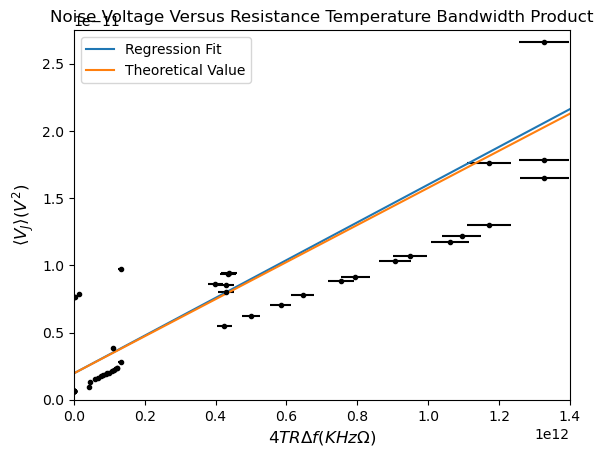

In [68]:
plt.errorbar(jInliers['Product'].to_numpy(), jInliers['Voltage'].to_numpy(), 
                             xerr=jInliers['dProduct'].to_numpy(), yerr=jInliers['Voltage Calc Error'].to_numpy(),
            linestyle='None', fmt='ko', markersize=3)
xfine = np.linspace(0, 1.4E12, 10000)
plt.plot(xfine, out.beta[0]*xfine + out.beta[1], label="Regression Fit")
plt.plot(xfine, xfine*1.38E-23 + out.beta[1], label="Theoretical Value")

plt.title("Noise Voltage Versus Resistance Temperature Bandwidth Product")
plt.ylabel(r"$\langle V_J \rangle (V^2)$", size = 12)
plt.xlabel(r"$4TR\Delta f(KHz\Omega)$", size = 12)
plt.legend()
plt.xlim(0, 1.4E12)
plt.ylim(0, 2.75E-11)
plt.show()

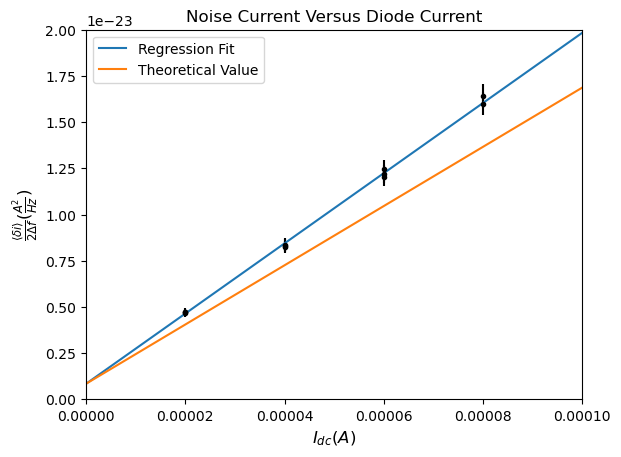

In [70]:
plt.errorbar(sInliers['Idc'].to_numpy(), sInliers['delsq2f'].to_numpy(), 
                             xerr=sInliers['dIdc'].to_numpy(), yerr=sInliers['ddelsq2f'].to_numpy(),
            linestyle='None', fmt='ko', markersize=3)
xfine = np.linspace(0, 12E-4, 10000)
plt.plot(xfine, sout.beta[0]*xfine + sout.beta[1], label="Regression Fit")
plt.plot(xfine, xfine*1.602E-19 + sout.beta[1], label="Theoretical Value")


plt.title("Noise Current Versus Diode Current")
plt.ylabel(r"$\frac{\langle \delta i \rangle}{2\Delta f}(\frac{A^2}{Hz})$", size = 12)
plt.xlabel(r"$I_{dc} (A)$", size = 12)
plt.legend()
plt.xlim(0, 0.00010)
plt.ylim(0, 2E-23)
plt.show()